In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.3)
import matplotlib.pyplot as plt

In [6]:
df = pd.read_stata('rd_ps.dta')
df.dropna(inplace=True)
df['T'] = df['T'].astype(int)
df.head()

,X,Y,T,ageshr19,ageshr60,buyuk,hischshr1520m,i89,lpop1994,merkezi,merkezp,partycount,prov,prov_num,sexr,shhs,subbuyuk,vshr_islam1994
0,-35.606632,22.962963,0,0.422086,0.075067,0.0,0.379310,0.0,7.996990,1.0,0.0,6.0,Adana,Adana,0.977481,4.670399,0.0,0.015448
1,-54.347824,25.438599,0,0.440988,0.063405,0.0,0.308901,0.0,7.362645,0.0,0.0,4.0,Adana,Adana,1.120342,6.813916,0.0,0.025136
2,-20.409229,22.682732,0,0.435477,0.055400,1.0,0.226284,0.0,13.175261,1.0,0.0,14.0,Adana,Adana,0.974625,4.389300,0.0,0.111115
3,-44.972065,15.853659,0,0.438675,0.066490,0.0,0.171171,0.0,7.623153,0.0,0.0,6.0,Adana,Adana,1.025215,5.510949,0.0,0.055866
4,-20.114943,18.238993,0,0.418107,0.054470,0.0,0.173134,0.0,7.647786,0.0,0.0,7.0,Adana,Adana,1.181073,6.234192,0.0,0.101881


In [7]:
df['wins_islam1994'] = 0
df['wins_islam1994'] = (df['X']>0).astype(int)

Some explanations for the variables: X = "Islamic vote margin in 1994", Y = "Share of women age 15-20 with high school education", T = "Islamic mayor in 1994"

To identify the situation when the Islamic party wins or loses the election, refer to the column vshr_islam1994, and this column gives the information "Islamic Vote Share in 1994". So, a win is identified when the share of the Islamic parties in the votes is above 50%. Thus, the indicator is $\mathbb{1}_{vshr\_islam1994>0,5}$, and the information is in the columns wins_islam1994.

Quoting from the paper:

*The forcing variable in this design is the win margin for the Islamic party rel-
ative to the largest non-Islamic party, and the cutoff is therefore* $c = 0$*. The
municipalities that fall below the cutoff* $(mi = 0)$*, the control group, receive
a secular mayor. Those above the cutoff, the treatment group* $(mi = 1)$*, re-
ceive an Islamic mayor. The assignment follows a known deterministic rule,*
$mi = \mathbb{1}_{xi ≥ c}$*, where* $\mathbb{1}_{\{\cdot\}}$ *is the indicator function.*

Then the running variable is given by the win-margin and the threshold is the Mayor indicator. 

In [17]:
axes_dict = {'Y':'Share of Women 15-20 years with HS Education',
             'X':'Islamic Voter Margin in 1994','T':'T=1, Islamic Mayor in 1994'}

**PART A.  Does the running variable lead to a sharp RD for the treatment?**

The running variable is the Islamic Voter Margin in 1994, and as described by the paper, the constituency receives a secular mayor when this margin is negative, and the constituency has an Islamic mayor when the margin is positive. That is, the running variable very clearly *delineates* the treatment and produces a **Sharp Regression Discontinuity**.

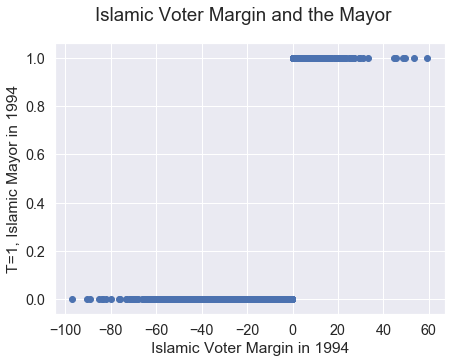

In [15]:
fig,axes = plt.subplots(1,1,figsize=(7,5))
fig.suptitle('Islamic Voter Margin and the Mayor')
plt.scatter(x = df["X"],y=df["T"])
plt.xlabel(axes_dict['X'])
plt.ylabel(axes_dict['T'])
plt.show()
plt.close()

**Part B. Generate the RD Plot of Y - Share Women aged 15-20 with High School education - against X - Islamic Vote Margin in 1994 - when the Islamic party wins and loses the election. Use 40 Evenly-Spaced Bins. Call the Y-axis Outcome and X-axis Running variable.**

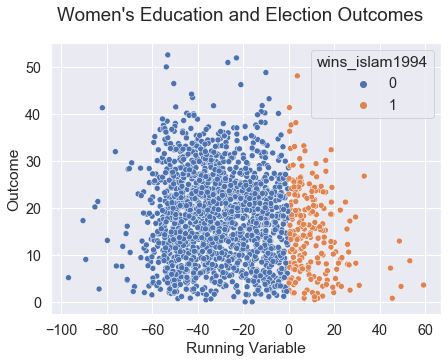

In [13]:
fig,axes = plt.subplots(1,1,figsize=(7,5))
fig.suptitle('Women\'s Education and Election Outcomes')
sns.scatterplot(data=df,x='X',y='Y',hue='wins_islam1994')
plt.xlabel('Running Variable')
plt.ylabel('Outcome')
plt.show()
plt.close()

In [2]:
import binsreg

def binscatter(**kwargs):
    # Estimate binsreg
    est = binsreg.binsreg(**kwargs)
    
    # Retrieve estimates
    df_est = pd.concat([d.dots for d in est.data_plot])
    df_est = df_est.rename(columns={'x': kwargs.get("x"), 'fit': kwargs.get("y")})
    
    # Add confidence intervals
    if "ci" in kwargs:
        df_est = pd.merge(df_est, pd.concat([d.ci for d in est.data_plot]))
        df_est = df_est.drop(columns=['x'])
        df_est['ci'] = df_est['ci_r'] - df_est['ci_l']
    
    # Rename groups
    if "by" in kwargs:
        df_est['group'] = df_est['group'].astype(df[kwargs.get("by")].dtype)
        df_est = df_est.rename(columns={'group': kwargs.get("by")})

    return df_est

In [8]:
df_est = binscatter(x='X', y='Y', data=df, ci=(3,3))
df_est.head()

,group,X,bin,isknot,mid,Y,ci_l,ci_r,ci
0,Full Sample,-64.520264,0,0,0,15.675017,12.369661,17.798846,5.429186
1,Full Sample,-54.463573,1,0,0,19.914334,16.811448,21.136540,4.325092
2,Full Sample,-51.891254,2,0,0,16.602479,15.964300,19.487008,3.522708
3,Full Sample,-49.829262,3,0,0,17.422299,15.278487,18.649405,3.370918
4,Full Sample,-47.601711,4,0,0,19.384861,17.231074,20.523004,3.291930


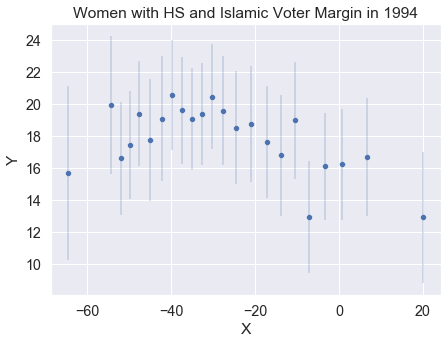

In [12]:
fig,axes = plt.subplots(1,1,figsize=(7,5))
sns.scatterplot(x='X', y='Y', data=df_est);
plt.errorbar('X', 'Y', yerr='ci', data=df_est, ls='', lw=2, alpha=0.2);
plt.title("Women with HS and Islamic Voter Margin in 1994")
plt.show()
plt.close()

**Part C. Estimate the effect of T - Islamic mayor in 1994 - on Y - Share Women aged 15-20 with High School Education. 
Use a linear polynomial. Try both an uniform and triangular kernel. Does electing a mayor from an Islamic 
party have a significant effect on the educational attainment of women?**

In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
df['constant'] = 1
df['X*T'] = df['X']*df['T']

The running varible is X, and the treatment is derived from the indicator, $T = \mathbb{1}_{X>0}$, so the interaction term is $X \cdot T$.

In [15]:
model = smf.wls('Y~X*T',df).fit()
print (model.summary())
df['pred_Y'] = model.predict()

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.020
Model:                            WLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     12.92
Date:                Fri, 02 Dec 2022   Prob (F-statistic):           2.36e-08
Time:                        22:35:36   Log-Likelihood:                -6933.1
No. Observations:                1908   AIC:                         1.387e+04
Df Residuals:                    1904   BIC:                         1.390e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.2191      0.478     36.025      0.0

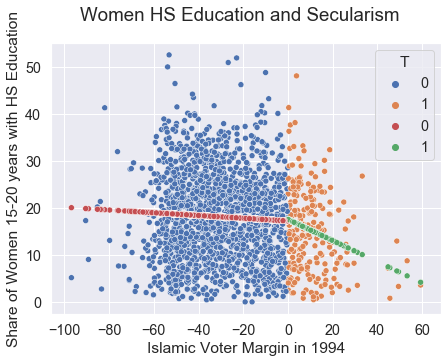

In [19]:
fig,axes = plt.subplots(1,1,figsize=(7,5))
fig.suptitle('Women HS Education and Secularism')
axes = sns.scatterplot(data=df, x='X',y='Y',hue='T')
axes = sns.scatterplot(data=df, x='X',y='pred_Y',hue='T',palette=['r','g'])
axes.set(xlabel = axes_dict['X'],ylabel = axes_dict['Y'])
plt.show()
plt.close()

In [20]:
def kernel(flag,R,c,h):
    indicator = (np.abs(R-c) <=h ).astype(float)
    if flag=='uniform': return indicator*0.5
    elif flag=='triangle': return (1-np.abs(R-c)/h)*indicator

In [21]:
from rdd import rdd
threshold=0

In [22]:
bw_opt = rdd.optimal_bandwidth(df['Y'],df['X'],cut=threshold)
print ('Optimal bandwidth = ',bw_opt)

Optimal bandwidth =  8.842252504790764


In [23]:
rdd_df = rdd.truncated_data(df,'X',bw_opt,cut=threshold)

In [24]:
rdd_df.head()

,X,Y,T,ageshr19,ageshr60,buyuk,hischshr1520m,i89,lpop1994,merkezi,...,prov,prov_num,sexr,shhs,subbuyuk,vshr_islam1994,wins_islam1994,constant,X*T,pred_Y
24,1.080075,37.654324,1,0.389573,0.087341,0.0,0.314978,0.0,7.981391,1.0,...,Adana,Adana,1.131201,5.012536,0.0,0.286406,1,1,1.080075,17.310638
34,-6.404774,18.095812,0,0.463055,0.045415,0.0,0.198216,0.0,11.873107,1.0,...,Adana,Adana,0.999678,4.781583,1.0,0.156132,0,1,-0.000000,17.406053
56,6.891891,15.501165,1,0.552096,0.055634,0.0,0.256826,0.0,8.091015,1.0,...,Adiyaman,Adiyaman,1.275765,7.252085,0.0,0.293919,1,1,6.891891,16.000969
57,-8.118812,4.430380,0,0.547005,0.058489,0.0,0.123077,1.0,7.498870,1.0,...,Adiyaman,Adiyaman,1.140395,7.038333,0.0,0.274587,0,1,-0.000000,17.456093
68,-2.043536,6.837607,0,0.462359,0.071100,0.0,0.105263,0.0,7.818430,0.0,...,Afyonkarahisar,Afyonkarahisar,0.946276,5.214831,0.0,0.247446,0,1,-0.000000,17.278729


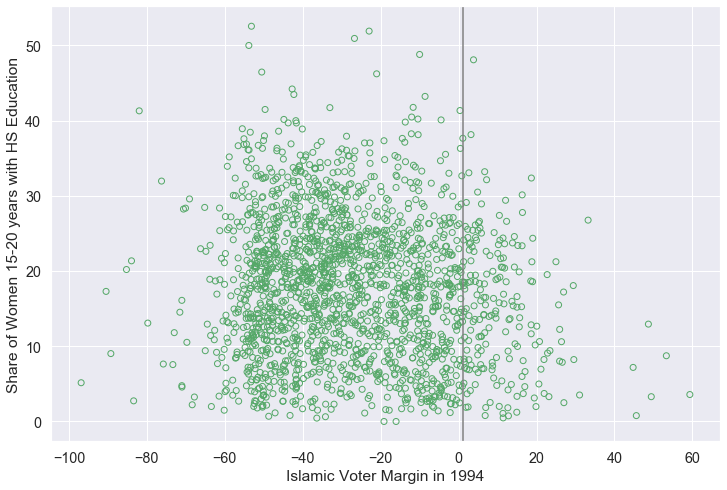

In [25]:
plt.figure(figsize=(12,8))
plt.scatter(df['X'],df['Y'],facecolors='none',edgecolors='g')
plt.xlabel(axes_dict['X'])
plt.ylabel(axes_dict['Y'])
plt.axvline(x=1,color='grey')
plt.show()

In [26]:
df['triangle_K'] = kernel('triangle',df['X'],c=threshold,h=bw_opt)
df['uniform_K'] = kernel('uniform',df['X'],c=threshold,h=bw_opt)

In [27]:
models={'Triangle Kernel Weights':0,'Uniform Kernel Weights':0,'No Kernel Weights':0}
models['Triangle Kernel Weights'] = smf.wls('Y~X*T',data=df,weights=df['triangle_K'])
models['Uniform Kernel Weights'] = smf.wls('Y~X*T',data=df,weights=df['uniform_K'])
models['No Kernel Weights'] = smf.wls('Y~X*T',data=rdd_df)

In [28]:
for mod in models:
    print ('WLS Estimation with ',mod)
    m=models[mod].fit(cov_type='hc3')
    print(m.summary())
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

WLS Estimation with  Triangle Kernel Weights
                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.013
Model:                            WLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.579
Date:                Fri, 02 Dec 2022   Prob (F-statistic):              0.192
Time:                        22:37:22   Log-Likelihood:                   -inf
No. Observations:                1908   AIC:                               inf
Df Residuals:                    1904   BIC:                               inf
Df Model:                           3                                         
Covariance Type:                  hc3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:740: RuntimeWarning: divide by zero encountered in log


The model specification with uniform, and hence equal weights, shows that the Treatment is statistically significant. Furthermore, the treatment is negative, so the Islamic Mayor has a decline in the Share of Women in High School.

**Part E. Estimate the effect of T on Y but using a local approach by restricting the sample to a window within the optimal bandwidth you obtained with the rdrobust command (mserd bandwidth). Use the regress command. Use a linear polynomial. Do you get the exact same result as in item (C)? If not, try to find out why and explain.**

From the above shown regression results, the last regression on the truncated dataframe with equal weights has the same regression output as the dataframe with uniform kernel. 

**Part F. Save the bandwidth of item (C) as a scalar named opt_i. Re-estimate RD ofitem (C) using the following alternative bandwidths: 0.5*opt_i, 0.75*opt_i, 1.25*opt_i, and 1.5*opt_i. Plot the five RD point estimates, including the one in items (C) with their confidence intervals in a graph. What can you say about robustness of the results with respect to bandwidth choice?**

In [66]:
opt_i = bw_opt 
bws = [opt_i*i for i in [0.5, 0.75, 1.25, 1.50]]

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.007
Model:                            WLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.3926
Date:                Fri, 02 Dec 2022   Prob (F-statistic):              0.758
Time:                        14:09:34   Log-Likelihood:                -616.22
No. Observations:                 170   AIC:                             1240.
Df Residuals:                     166   BIC:                             1253.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.6632      2.089      7.498      0.0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


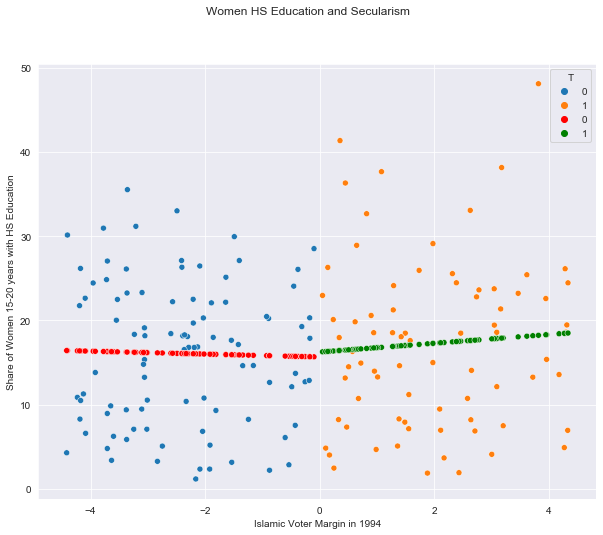

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.016
Model:                            WLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.265
Date:                Fri, 02 Dec 2022   Prob (F-statistic):              0.287
Time:                        14:09:35   Log-Likelihood:                -879.00
No. Observations:                 244   AIC:                             1766.
Df Residuals:                     240   BIC:                             1780.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.0299      1.606     10.603      0.0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


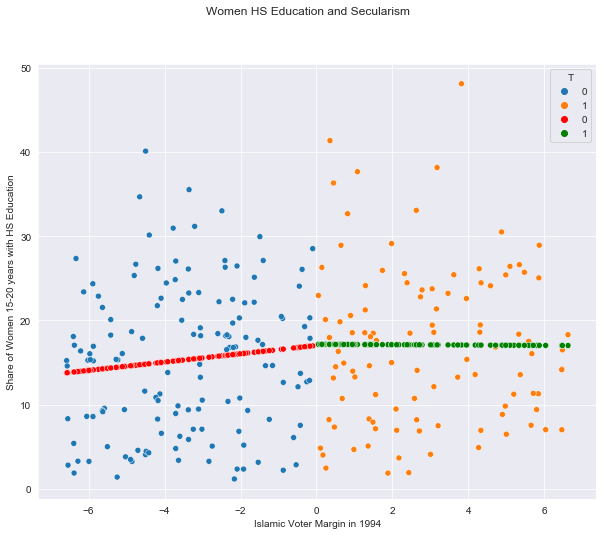

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.006
Model:                            WLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7469
Date:                Fri, 02 Dec 2022   Prob (F-statistic):              0.525
Time:                        14:09:37   Log-Likelihood:                -1434.5
No. Observations:                 396   AIC:                             2877.
Df Residuals:                     392   BIC:                             2893.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.7921      1.195     12.378      0.0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


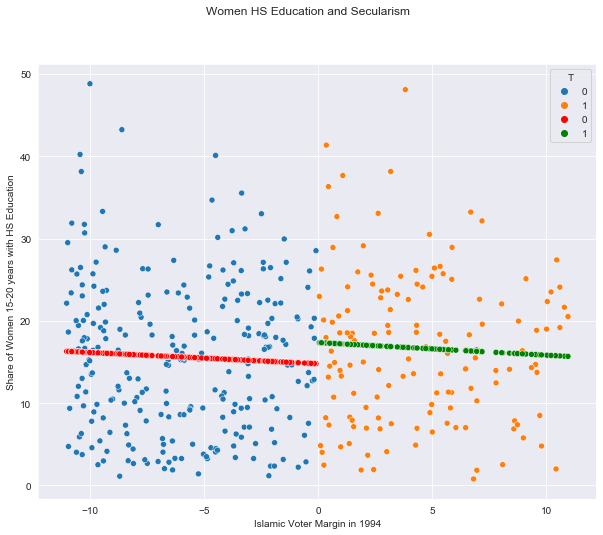

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.012
Model:                            WLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.906
Date:                Fri, 02 Dec 2022   Prob (F-statistic):              0.128
Time:                        14:09:38   Log-Likelihood:                -1662.7
No. Observations:                 457   AIC:                             3333.
Df Residuals:                     453   BIC:                             3350.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.1991      1.133     12.531      0.0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


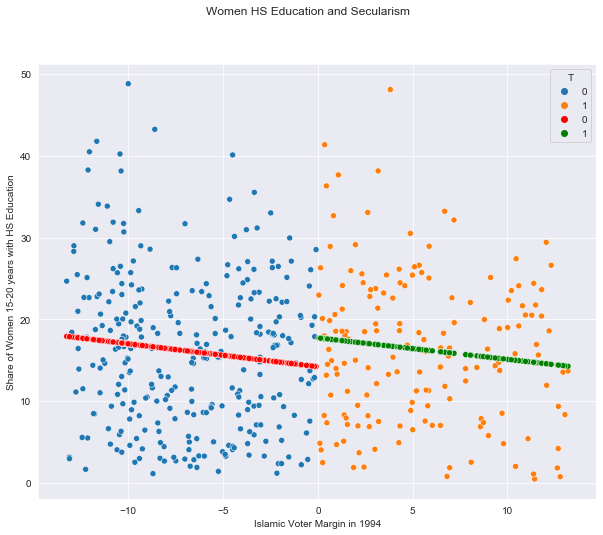

In [68]:
for bw in bws:
    rdd_df = rdd.truncated_data(df,'X',bw,cut=threshold)
    model = smf.wls('Y~X*T',rdd_df).fit()
    print (model.summary())
    rdd_df['pred_Y'] = model.predict()
    fig,axes = plt.subplots(1,1,figsize=(10,8))
    fig.suptitle('Women HS Education and Secularism')
    axes = sns.scatterplot(data=rdd_df, x='X',y='Y',hue='T')
    axes = sns.scatterplot(data=rdd_df, x='X',y='pred_Y',hue='T',palette=['r','g'])
    axes.set(xlabel = axes_dict['X'],ylabel = axes_dict['Y'])
    plt.show()
    plt.close()

The bandwidth affects the slope of the regression discontinuity.